In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
BASE_DIR = '/content/drive/MyDrive/SoftProject'
os.chdir('/content/drive/MyDrive/prout')
WORKING_DIR = os.getcwd()

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8100 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [5]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [6]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()


In [7]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [8]:
len(mapping)

8091

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [10]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
# preprocess the text
clean(mapping)

In [12]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [13]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
len(all_captions)

40455

In [15]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [16]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
vocab_size

8485

In [18]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [20]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [21]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    """
    Efficient data generator for training.

    Args:
        data_keys: List of image keys.
        mapping: Dictionary mapping image keys to their captions.
        features: Dictionary mapping image keys to image features.
        tokenizer: Tokenizer for text processing.
        max_length: Maximum length of a caption.
        vocab_size: Size of the vocabulary.
        batch_size: Number of samples per batch.

    Yields:
        A tuple of inputs (image features, text sequences) and outputs (target sequences).
    """
    X1, X2, y = [], [], []
    n = 0  # Track the number of samples in the current batch

    while True:  # Infinite generator loop
        for key in data_keys:
            captions = mapping[key]  # Retrieve captions for this key

            for caption in captions:
                # Tokenize and encode the caption sequence
                seq = tokenizer.texts_to_sequences([caption])[0]

                # Generate input-output pairs from the sequence
                for i in range(1, len(seq)):
                    # Split into input (in_seq) and output (out_seq)
                    in_seq, out_seq = seq[:i], seq[i]

                    # Pad the input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    # Store image feature, input sequence, and target word index
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

                    n += 1

                    # If batch is full, yield the batch
                    if n == batch_size:
                        yield (
                            {"image": np.array(X1), "text": np.array(X2)},
                            np.array(y),
                        )
                        # Reset batch variables
                        X1, X2, y = [], [], []
                        n = 0


In [22]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

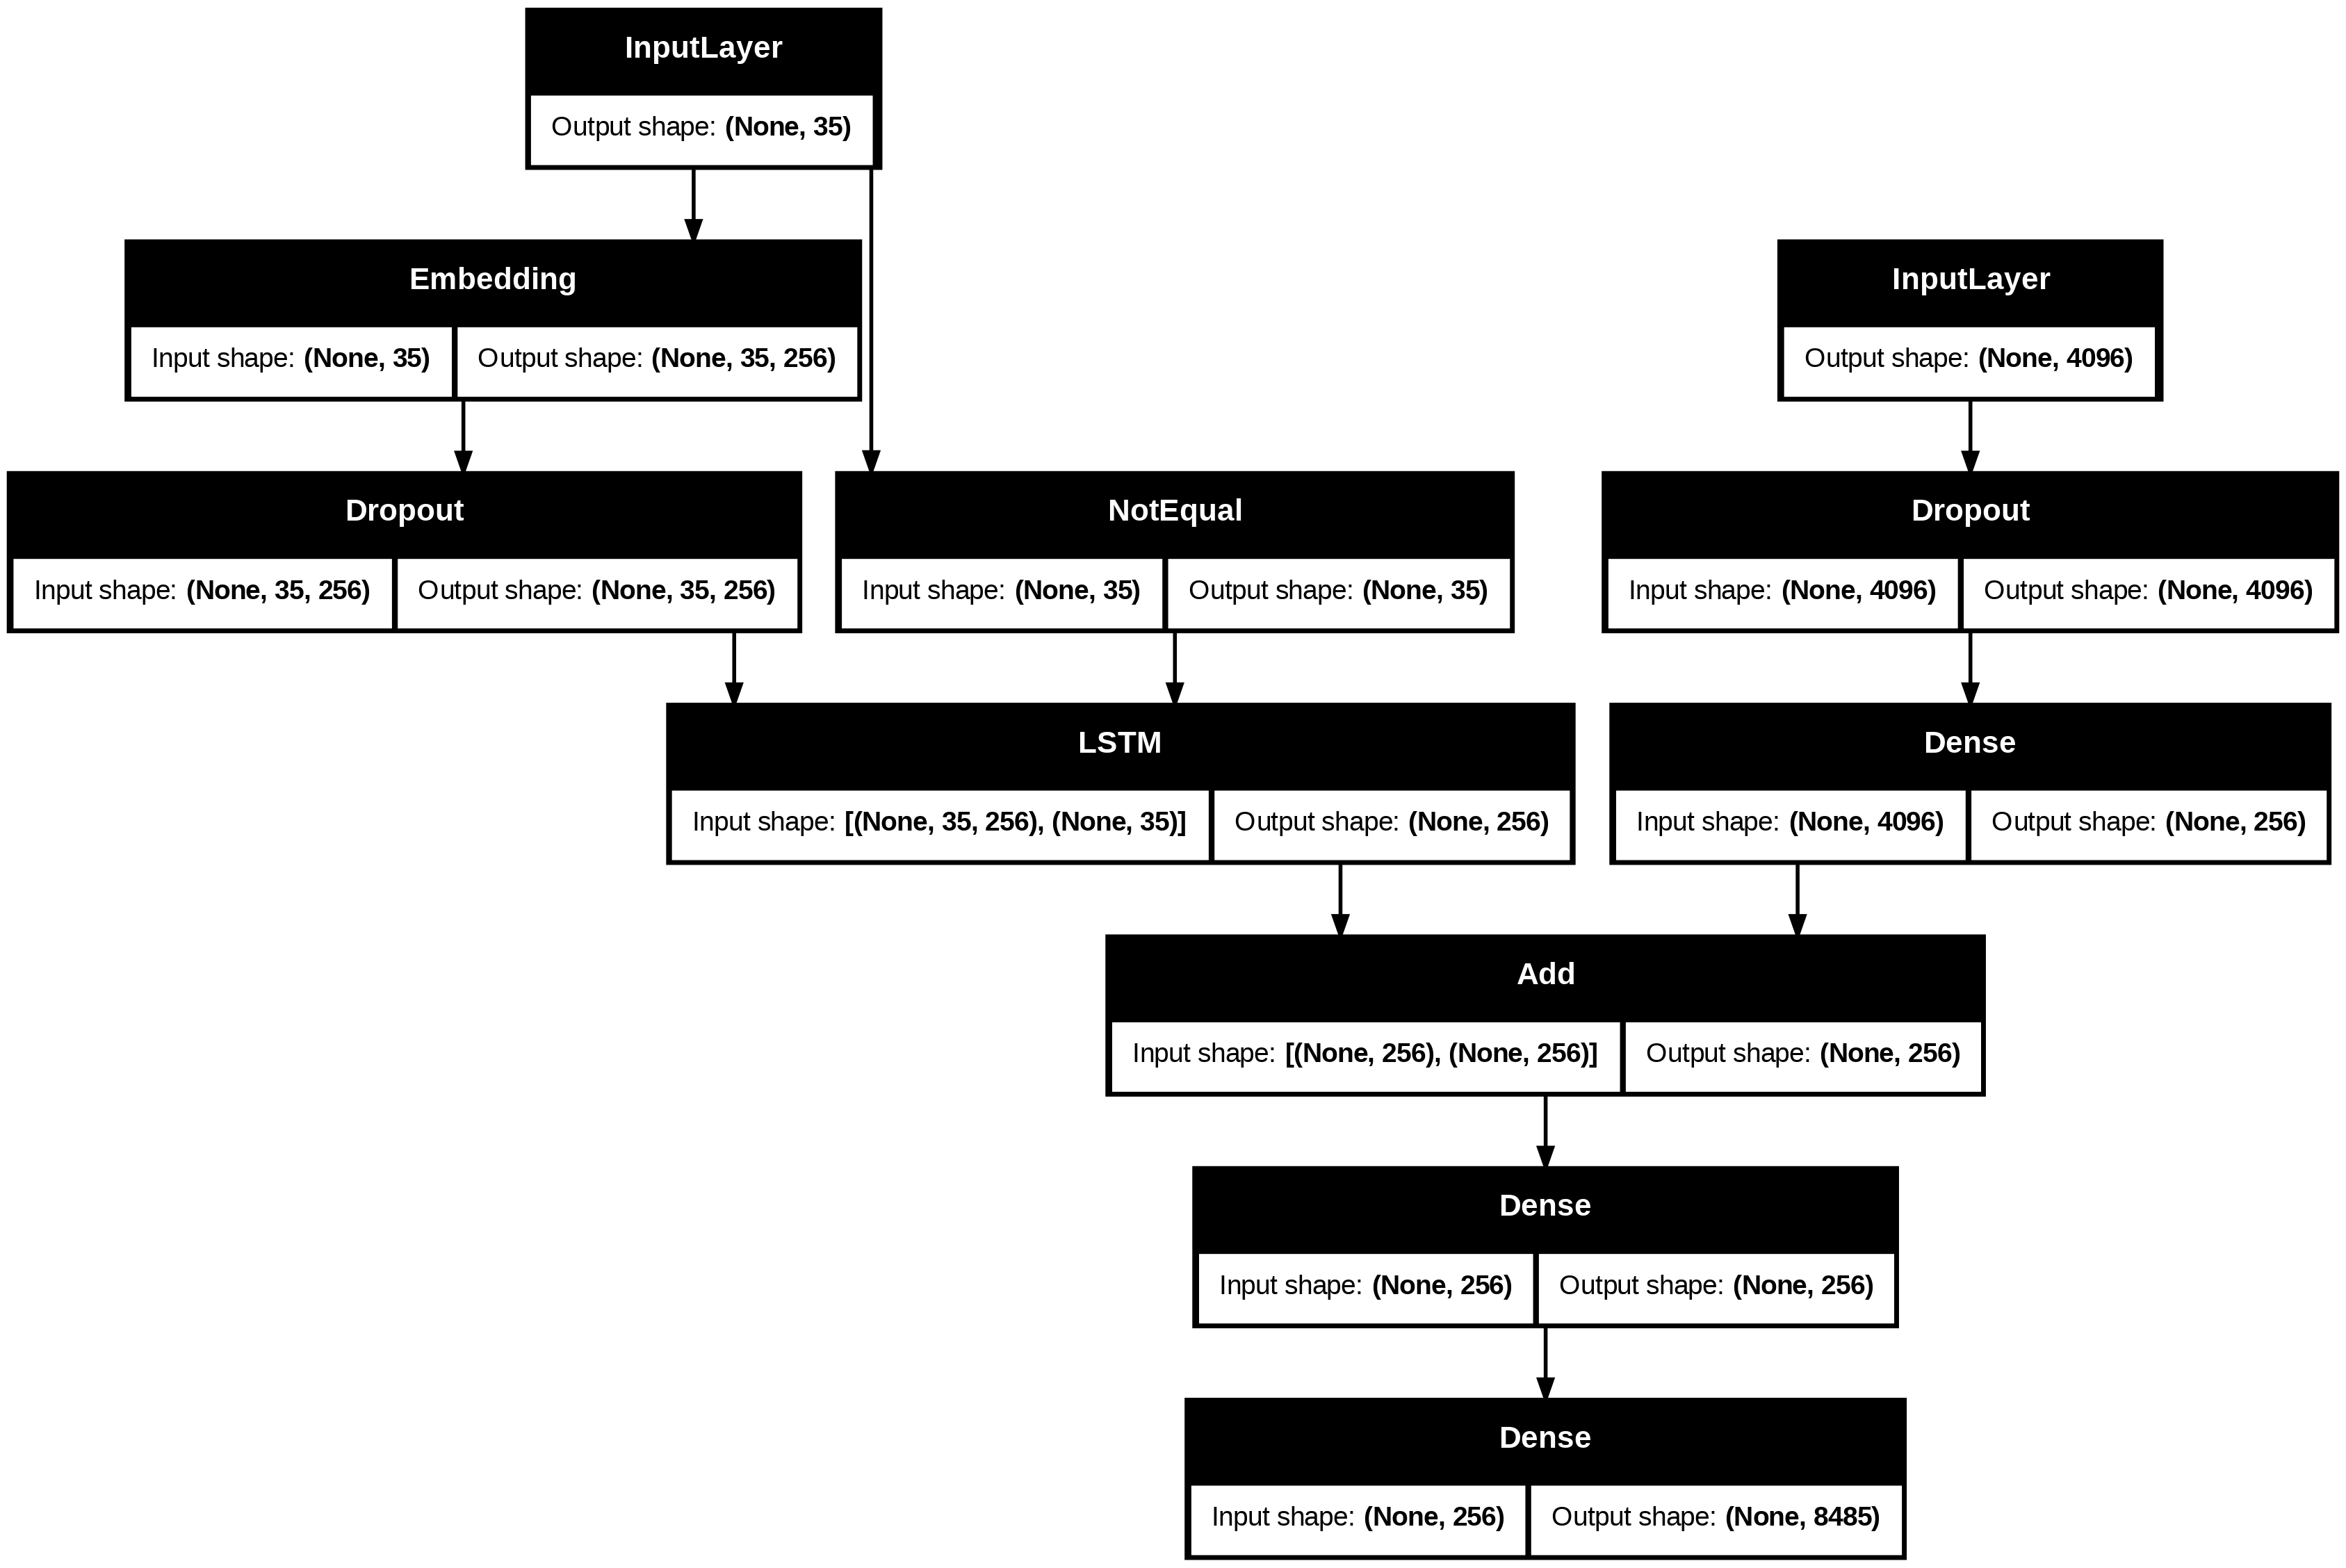

In [23]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [24]:
  # train the model
epochs = 20
batch_size = 16
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

455/455 ━━━━━━━━━━━━━━━━━━━━ 604s 1s/step - loss: 5.4780
455/455 ━━━━━━━━━━━━━━━━━━━━ 72s 157ms/step - loss: 3.8877
455/455 ━━━━━━━━━━━━━━━━━━━━ 72s 157ms/step - loss: 3.4736
455/455 ━━━━━━━━━━━━━━━━━━━━ 69s 153ms/step - loss: 3.2064
455/455 ━━━━━━━━━━━━━━━━━━━━ 71s 157ms/step - loss: 3.0033
455/455 ━━━━━━━━━━━━━━━━━━━━ 70s 154ms/step - loss: 2.8511
455/455 ━━━━━━━━━━━━━━━━━━━━ 71s 155ms/step - loss: 2.7287
455/455 ━━━━━━━━━━━━━━━━━━━━ 71s 157ms/step - loss: 2.6371
455/455 ━━━━━━━━━━━━━━━━━━━━ 70s 155ms/step - loss: 2.5598
455/455 ━━━━━━━━━━━━━━━━━━━━ 72s 158ms/step - loss: 2.4953
455/455 ━━━━━━━━━━━━━━━━━━━━ 72s 157ms/step - loss: 2.4371
455/455 ━━━━━━━━━━━━━━━━━━━━ 72s 158ms/step - loss: 2.3803
455/455 ━━━━━━━━━━━━━━━━━━━━ 70s 154ms/step - loss: 2.3299
455/455 ━━━━━━━━━━━━━━━━━━━━ 72s 159ms/step - loss: 2.2858
455/455 ━━━━━━━━━━━━━━━━━━━━ 72s 158ms/step - loss: 2.2447
455/455 ━━━━━━━━━━━━━━━━━━━━ 72s 159ms/step - loss: 2.2074
455/455 ━━━━━━━━━━━━━━━━━━━━ 72s 157ms/step - loss: 2.1753

In [40]:
# save the model
model.save(WORKING_DIR+'/trainedmodel.keras')

In [42]:
from keras.models import load_model
loaded_model = load_model(WORKING_DIR+'/trainedmodel.keras')

In [43]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [44]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [48]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [46]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs play with each other endseq


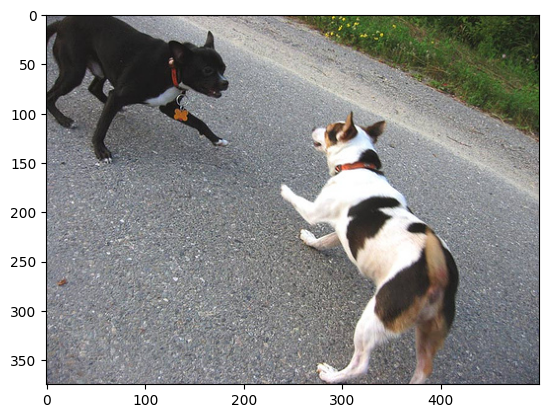

In [47]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq two girls in brightly clothes sitting in the grass endseq


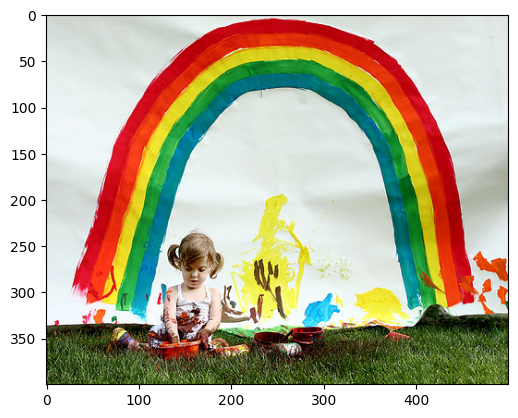

In [49]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq man in red jacket and backpack stands in the snow endseq


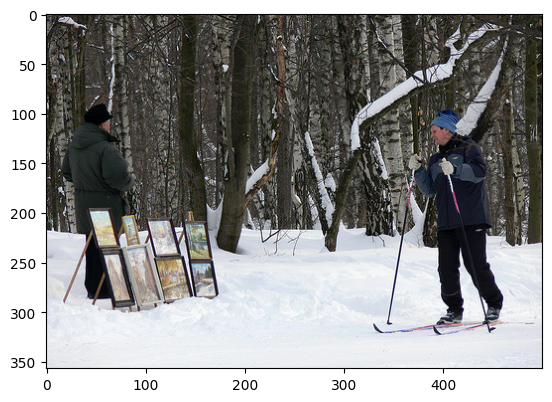

In [50]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq man is standing on top of mountain gazing at the sunset endseq
startseq man is standing on top of rock or mountain watching the sunset endseq
startseq man 's sillouhette at sunset endseq
startseq man standing in the mountains watching sunset endseq
startseq man stands on hill at dusk endseq
--------------------Predicted--------------------
startseq man in black jacket and sunglasses is climbing up mountain endseq


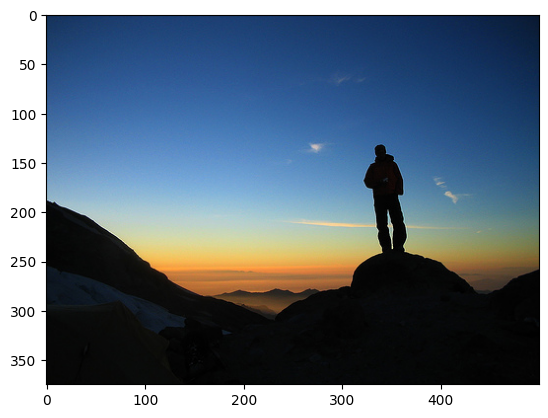

In [51]:
generate_caption("58368365_03ed3e5bdf.jpg")

---------------------Actual---------------------
startseq dog is running along beach on sunny day endseq
startseq dog running at the beach in front of the ocean and bright blue cloudy sky endseq
startseq dog runs along the short at beach endseq
startseq lean dog runs along the beach endseq
startseq slender dog running in the sand on sunny day endseq
--------------------Predicted--------------------
startseq dog running on the beach endseq


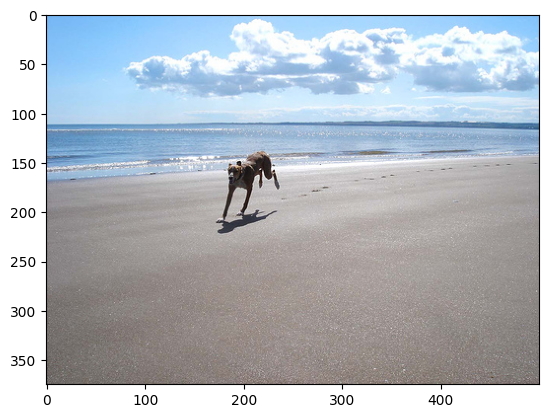

In [52]:
generate_caption("140430106_2978fda105.jpg")

---------------------Actual---------------------
startseq man is riding on red motorcycle endseq
startseq motorcycle driver dressed in orange gear swerves to the right endseq
startseq motorcyclist on red speed bike leans into sharp turn endseq
startseq motorcyclist crouches low as he rounds turn endseq
startseq this person is on red motorcycle endseq
--------------------Predicted--------------------
startseq motorcycle racer in red and red helmet is racing on the street endseq


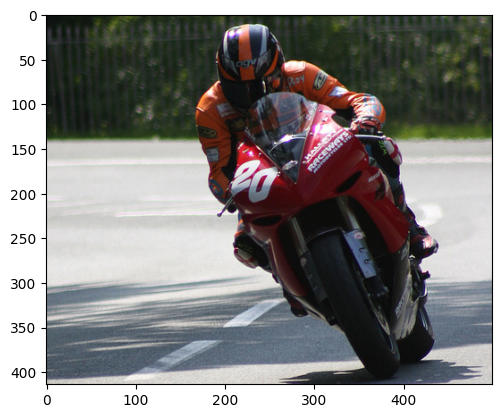

In [33]:
generate_caption("166321294_4a5e68535f.jpg")

In [34]:
# Assuming you have already defined and trained your tokenizer
# tokenizer = ...

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

# Example usage
generate_caption("667626_18933d713e.jpg")


---------------------Actual---------------------
startseq girl is stretched out in shallow water endseq
startseq girl wearing red and multi-colored bikini is laying on her back in shallow water endseq
startseq little girl in red swimsuit is laying on her back in shallow water endseq
startseq "a young girl is lying in the sand while ocean water is surrounding her ." endseq
startseq girl wearing bikini lying on her back in shallow pool of clear blue water endseq
--------------------Predicted--------------------
startseq small boy is wearing goggles and swimming and trying to catch white and yellow toy in its mouth endseq


In [36]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [37]:
image_path = '/content/drive/MyDrive/SoftProject/Images/1007320043_627395c3d8.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


'startseq child grips the ropes endseq'